PS2
Yuqian Gong

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd


Question 1 

(a)

In [2]:
bq_data = np.loadtxt('BQmat_orig.txt', delimiter=',')

In [15]:
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
cmap1 = matplotlib.cm.get_cmap('summer')
bq_data.shape

(78, 7)

In [29]:
ages_vec = np.arange(18, 96)
abils_midpt = np.array([0.125, 0.375, 0.60, 0.75, 0.85, 0.94, 0.995])

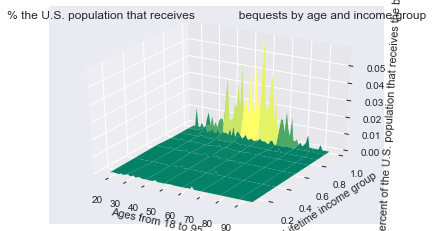

In [58]:
y_mesh, x_mesh = np.meshgrid(abils_midpt, ages_vec)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(x_mesh, y_mesh, bq_data, 
                cstride=1, cmap=cmap1)
ax.set_title('% the U.S. population that receives\
             bequests by age and income group')
ax.set_xlabel('Ages from 18 to 95')
ax.set_ylabel('Lifetime income group')
ax.set_zlabel('Percent of the U.S. population that receives the bequests')

(b)

In [53]:
from scipy.stats import gaussian_kde
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import LeaveOneOut
from sklearn.neighbors import KernelDensity

prop_mat_inc = np.sum(bq_data, axis=0)
prop_mat_age = np.sum(bq_data, axis=1)
lrg_samp = 70000
age_probs = np.random.multinomial(lrg_samp, prop_mat_age)
income_probs = np.random.multinomial(lrg_samp, prop_mat_inc)
age_freq = np.array([])
inc_freq = np.array([])

# creating a distribution of age values
for age, num_s in zip(ages_vec, age_probs):
    vec_age_s = np.ones(num_s)
    vec_age_s *= age
    age_freq = np.append(age_freq, vec_age_s)

# creating a distribution of ability type values
for abil, num_j in zip(abils_midpt, income_probs):
    vec_abil_j = np.ones(num_j)
    vec_abil_j *= abil
    inc_freq = np.append(inc_freq, vec_abil_j)

data = np.vstack((age_freq, inc_freq))





In [62]:
#find best bandwidth
from sklearn.cross_validation import KFold
bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=KFold(20))
grid.fit(data.T) 
best_bandwidth = grid.best_params_['bandwidth']


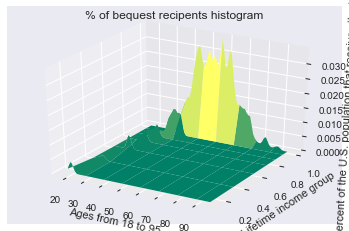

In [60]:
density = gaussian_kde(data, bw_method=best_bandwidth)     
coords = np.vstack([item.ravel() for item in [x_mesh, y_mesh]])
BQkde = density(coords).reshape(x_mesh.shape)
BQkde_scaled = BQkde / np.sum(BQkde)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(x_mesh, y_mesh, BQkde_scaled, 
                cstride=1, cmap=cmap1)
ax.set_title('% of bequest recipents histogram')
ax.set_xlabel('Ages from 18 to 95')
ax.set_ylabel('Lifetime income group')
ax.set_zlabel('Percent of the U.S. population that receives the bequests')

Question 2 (a) 

In [66]:
biden_data = pd.read_csv("biden.csv")
biden_data.head()

,biden,female,age,educ,dem,rep
0,90.0,0,19.0,12.0,1.0,0.0
1,70.0,1,51.0,14.0,1.0,0.0
2,60.0,0,27.0,14.0,0.0,0.0
3,50.0,1,43.0,14.0,1.0,0.0
4,60.0,1,38.0,14.0,0.0,1.0


In [70]:
import statsmodels.formula.api as smf
biden_data['interaction'] = biden_data['age'] * biden_data['educ']
mod = smf.ols(formula='biden ~ age + educ + interaction', data=biden_data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  biden   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     10.13
Date:                Mon, 30 Apr 2018   Prob (F-statistic):           1.29e-06
Time:                        10:46:33   Log-Likelihood:                -8333.3
No. Observations:                1826   AIC:                         1.667e+04
Df Residuals:                    1822   BIC:                         1.670e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      37.5491      9.491      3.956      

In [76]:

beta_const = res.params['Intercept']
beta_age = res.params['age']
beta_educ = res.params['educ']
beta_inter = res.params['interaction']

In [77]:
res.params

Intercept      37.549089
age             0.667404
educ            1.712293
interaction    -0.047709
dtype: float64

In [128]:
educ_vals = np.linspace(biden_data['educ'].min(), biden_data['educ'].max(),200)
age_vals = np.linspace(biden_data['age'].min(), biden_data['age'].max(),200)
marg_age = beta_age + beta_inter * educ_vals
marg_educ = beta_educ + beta_inter * age_vals

The marginal effect of age is beta_age + beta_inter * educ, which is 0.667 - 0.048 * educ.
The marginal effect of education is beta_educ + beta_inter * age, which is 1.712 - 0.0048 * age.

In [115]:
res.cov_params()

,Intercept,age,educ,interaction
Intercept,90.077473,-1.520617,-6.629478,0.112692
age,-1.520617,0.028545,0.112425,-0.002122
educ,-6.629478,0.112425,0.502923,-0.008616
interaction,0.112692,-0.002122,-0.008616,0.000164


In [129]:
var_age = res.cov_params()['age']['age']
var_educ = res.cov_params()['educ']['educ']
var_inter = res.cov_params()['interaction']['interaction']
cov_age_inter = res.cov_params()['age']['interaction']
cov_educ_inter = res.cov_params()['educ']['interaction']

In [130]:
var_marg_age = var_age + (educ_vals ** 2) * var_inter + (educ_vals) * cov_age_inter
std_marg_age = np.sqrt(var_marg_age)
var_marg_educ = var_educ + (age_vals ** 2) * var_inter + (age_vals) * cov_educ_inter
std_marg_educ = np.sqrt(var_marg_educ)
age_upper = marg_age + 2 * std_marg_age
age_lower = marg_age - 2 * std_marg_age
educ_upper = marg_educ + 2 * std_marg_educ
educ_lower = marg_educ - 2 * std_marg_educ

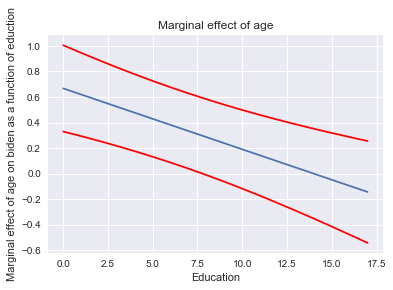

In [131]:
plt.plot(educ_vals, marg_age )
plt.plot(educ_vals, age_upper, color='r')
plt.plot(educ_vals, age_lower, color='r')
plt.xlabel('Education')
plt.ylabel('Marginal effect of age on biden as a function of eduction')
plt.title('Marginal effect of age')

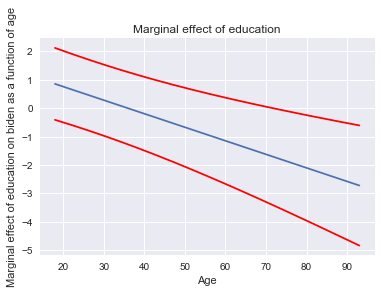

In [132]:
plt.plot(age_vals, marg_educ )
plt.plot(age_vals, educ_upper, color='r')
plt.plot(age_vals, educ_lower, color='r')
plt.xlabel('Age')
plt.ylabel('Marginal effect of education on biden as a function of age')
plt.title('Marginal effect of education')